# EXP02 de MC504
para executar o jupyter como root:
 - sudo -E env "PATH=$PATH" jupyter notebook --allow-root

In [1]:
#made by Fabio Stori [196631] and Felipe Duarte Domingues [171036] - 

In [3]:
import os
import psutil
import subprocess
import sysconfig

from bitstring import BitArray

In [4]:
# Iterate over all running process, use this just to choose one process you like
for proc in psutil.process_iter():
    try:
        print("PID: %d, Name: %s" % (proc.pid, proc.name()))
    except Exception as e:
        pass

PID: 1, Name: systemd
PID: 2, Name: kthreadd
PID: 3, Name: rcu_gp
PID: 4, Name: rcu_par_gp
PID: 5, Name: kworker/0:0-events
PID: 6, Name: kworker/0:0H-kblockd
PID: 7, Name: kworker/u2:0-events_power_efficient
PID: 8, Name: mm_percpu_wq
PID: 9, Name: ksoftirqd/0
PID: 10, Name: rcu_sched
PID: 11, Name: migration/0
PID: 12, Name: idle_inject/0
PID: 14, Name: cpuhp/0
PID: 15, Name: kdevtmpfs
PID: 16, Name: netns
PID: 17, Name: rcu_tasks_kthre
PID: 18, Name: kauditd
PID: 19, Name: khungtaskd
PID: 20, Name: oom_reaper
PID: 21, Name: writeback
PID: 22, Name: kcompactd0
PID: 23, Name: ksmd
PID: 24, Name: khugepaged
PID: 25, Name: crypto
PID: 26, Name: kintegrityd
PID: 27, Name: kblockd
PID: 28, Name: tpm_dev_wq
PID: 29, Name: ata_sff
PID: 30, Name: md
PID: 31, Name: edac-poller
PID: 32, Name: devfreq_wq
PID: 33, Name: watchdogd
PID: 36, Name: kworker/0:2-events
PID: 39, Name: kswapd0
PID: 40, Name: kworker/u3:0
PID: 41, Name: ecryptfs-kthrea
PID: 130, Name: kthrotld
PID: 131, Name: acpi_therma

In [5]:
pid = 2747
process = psutil.Process(pid)

process.cmdline(), process.name()

(['/usr/lib/libreoffice/program/soffice.bin', '--writer'], 'soffice.bin')

In [6]:
out, err = subprocess.Popen("getconf PAGE_SIZE", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE).communicate()
VIRTUAL_PAGE_SIZE = int(out.strip())
VIRTUAL_PAGE_SIZE

4096

In [7]:
out, err = subprocess.Popen("whoami", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE).communicate()
if b"root" not in out:
    print("You need to be root")
else:
    print("You are good to go")

You are good to go


In [8]:
# simple function using shifts to get the n bit from the x uint
get_bit = lambda x,n: (x & (1<<n)) >> n

# the same as * 8, as each page map entry uses 64 bits (8 bytes) shifting a page map index by 3 bits 
# returns the offset in /proc/{pid}/pagemap
PAGE_MAP_ENTRY = lambda x: x << 3 

# for a 4k page (the usual) that`s the same as shifting 12 bits to get the page map table index
PAGE_MAP_TABLE_INDEX = lambda x: int(x/VIRTUAL_PAGE_SIZE)

In [9]:
def pages_memory(pid):
    process_maps = open("/proc/%d/maps" % pid).read()
    PAGEMAP_ENTRY = 8 # number of bytes for each page in pagemap table (it uses a total of 64 bits for each page)
    for mapping in process_maps.split("\n")[:-1]:
        args = mapping.split(" ")
        address, perms, file_offset, dev, inode, pathname = (*args[0:5], args[-1])
        address_start, address_end = (int(x, base=16) for x in address.split("-"))

        #http://fivelinesofcode.blogspot.com/2014/03/how-to-translate-virtual-to-physical.html
        process_virtual_pages = dict(address_start=address_start,
                                     address_start_hex=hex(address_start),
                                     address_end=address_end,
                                     address_end_hex=hex(address_end),
                                     perms=perms,
                                     dev=dev,
                                     inode=inode,
                                     pathname=pathname)
        with open("/proc/%d/pagemap" % pid, "rb") as p:
            #print(process_virtual_pages)
            for page_start_address in range(address_start, address_end, 4096):
                pagemap_table_index = PAGE_MAP_TABLE_INDEX(page_start_address)
                pagemap_table_offset = PAGE_MAP_ENTRY(pagemap_table_index) # that's the byte address inside the pagemap table
                
                p.seek(pagemap_table_offset)
                entry = p.read(8) # read 8 bytes (64 bits)
                entry_uint = int.from_bytes(entry, 'little')
                if get_bit(entry_uint, 63): #page is present in ram
                    #print(hex(pagemap_table_offset))
                    #page_frame_number = int.from_bytes(entry_bit_array[0:54].hex, 'little') & 0x7FFFFFFFFFFFFF # unsigned int...
                    page_frame_number = entry_uint & 0x7FFFFFFFFFFFFF
                    if page_start_address == 0x3eaa000:
                        print(page_frame_number)
                    yield page_start_address, page_frame_number             

In [10]:
def pages_swap(pid):
    process_maps = open("/proc/%d/maps" % pid).read()
    PAGEMAP_ENTRY = 8 # number of bytes for each page in pagemap table (it uses a total of 64 bits for each page)
    for mapping in process_maps.split("\n")[:-1]:
        args = mapping.split(" ")
        address, perms, file_offset, dev, inode, pathname = (*args[0:5], args[-1])
        address_start, address_end = (int(x, base=16) for x in address.split("-"))

        #http://fivelinesofcode.blogspot.com/2014/03/how-to-translate-virtual-to-physical.html
        process_virtual_pages = dict(address_start=address_start,
                                     address_start_hex=hex(address_start),
                                     address_end=address_end,
                                     address_end_hex=hex(address_end),
                                     perms=perms,
                                     dev=dev,
                                     inode=inode,
                                     pathname=pathname)
        with open("/proc/%d/pagemap" % pid, "rb") as p:
            for page_start_address in range(address_start, address_end, 4096):
                pagemap_table_index = int(page_start_address / VIRTUAL_PAGE_SIZE)
                pagemap_table_offset = pagemap_table_index * PAGEMAP_ENTRY; # that's the byte address inside the pagemap table
                
                p.seek(pagemap_table_offset)
                entry = p.read(8) # read 8 bytes (64 bits)
                entry_uint = int.from_bytes(entry, 'little')
                if get_bit(entry_uint, 62): # swapped
                    #swap_type = bits from [0:4]
                    #swap_offset= bits from [5:54]
                    yield page_start_address

In [11]:
[(hex(x[0]), hex(x[1])) for x in pages_memory(pid)]
#[(int(x[0]), int(x[1])) for x in pages_memory(pid)]    

[('0x5592dcb70000', '0x64f22'),
 ('0x5592dcd70000', '0x51243'),
 ('0x5592dcd71000', '0x51241'),
 ('0x5592deb5c000', '0x5cde2'),
 ('0x5592deb6d000', '0x52f10'),
 ('0x5592deb6e000', '0x52f17'),
 ('0x5592deb6f000', '0x52faa'),
 ('0x5592deb70000', '0x52fcb'),
 ('0x5592deb71000', '0x52fcd'),
 ('0x5592deb72000', '0x52820'),
 ('0x5592deb73000', '0x52828'),
 ('0x5592deb74000', '0x5282b'),
 ('0x5592deb75000', '0x5282e'),
 ('0x5592deb76000', '0x52832'),
 ('0x5592deb77000', '0x52834'),
 ('0x5592deb78000', '0x528ad'),
 ('0x5592deb79000', '0xb1695'),
 ('0x5592deb7a000', '0x57df9'),
 ('0x5592deb7b000', '0x6f136'),
 ('0x5592deb7c000', '0x6f16f'),
 ('0x5592deb7d000', '0x6f172'),
 ('0x5592deb7e000', '0x65992'),
 ('0x5592deb7f000', '0x6f189'),
 ('0x5592deb80000', '0x615eb'),
 ('0x5592deb81000', '0x6f196'),
 ('0x5592deb82000', '0x62128'),
 ('0x5592deb83000', '0x6d349'),
 ('0x5592deb84000', '0x652ab'),
 ('0x5592deb85000', '0x6f680'),
 ('0x5592deb86000', '0x52abf'),
 ('0x5592deb87000', '0x52ac1'),
 ('0x559

In [12]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math

pages = []

for f in pages_memory(pid):
    pages.append(int(f[1]))   

pages.sort()

x = [i for i in range(129)]
xGridLength = (pages[len(pages)-1] - pages[0]) / 128

y = []
y[:129] = [0] * 129

for j in range(len(pages)):
    thisPage = pages[j] - pages[0]
    thisPage = thisPage / xGridLength
    thisPage = math.floor(thisPage)
    y[thisPage] = y[thisPage] + 1

print('Há um total de ',len(pages),' page frames mapeados para esse processo')

Há um total de  39290  page frames mapeados para esse processo


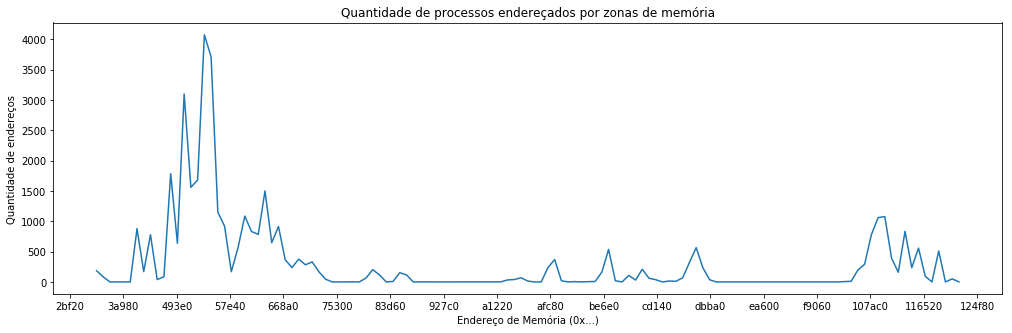

In [13]:
plt.figure(figsize=(17,5))
for i in range(129):
    x[i] = (i*xGridLength)+pages[0]    

def to_hex(x, pos):
    return '%x' % int(x)

fmt = ticker.FuncFormatter(to_hex)

plt.plot(x,y)

#https://stackoverflow.com/questions/21189806/hexadecimal-x-axis-in-matplotlib
axes = plt.gca()
axes.get_xaxis().set_major_locator(ticker.MultipleLocator(60000))
axes.get_xaxis().set_major_formatter(fmt)

plt.title('Quantidade de processos endereçados por zonas de memória')
plt.xlabel('Endereço de Memória (0x...)')
plt.ylabel('Quantidade de endereços')
plt.show()

In [14]:
allPages = []

for proc in psutil.process_iter():
    for f in pages_memory(proc.pid):
        allPages.append(int(f[1]))   
        
allPages.sort()

x = [i for i in range(129)]
xGridLength = (allPages[len(allPages)-1] - allPages[0]) / 128

y = []
y[:129] = [0] * 129

for j in range(len(allPages)):
    thisPage = allPages[j] - allPages[0]
    thisPage = thisPage / xGridLength
    thisPage = math.floor(thisPage)
    y[thisPage] = y[thisPage] + 1
    
print('Há um total de ',len(allPages),' page frames mapeados para todos os processos da máquina')

Há um total de  892093  page frames mapeados para todos os processos da máquina


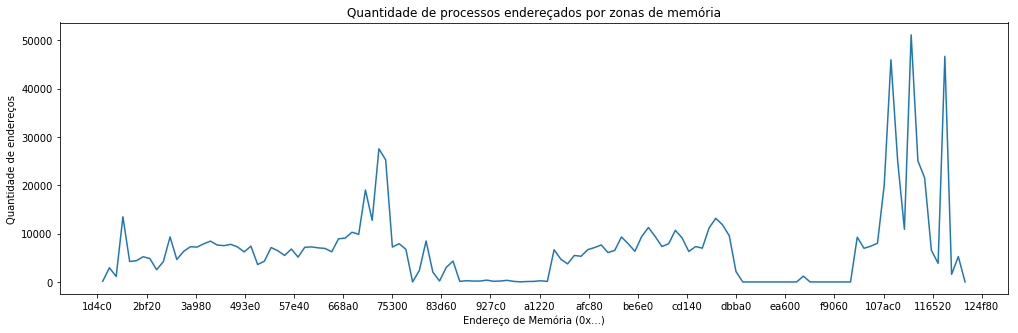

In [15]:
plt.figure(figsize=(17,5))
for i in range(129):
    x[i] = (i*xGridLength)+allPages[0]    

def to_hex(x, pos):
    return '%x' % int(x)

fmt = ticker.FuncFormatter(to_hex)

plt.plot(x,y)

axes = plt.gca()
axes.get_xaxis().set_major_locator(ticker.MultipleLocator(60000))
axes.get_xaxis().set_major_formatter(fmt)

plt.title('Quantidade de processos endereçados por zonas de memória')
plt.xlabel('Endereço de Memória (0x...)')
plt.ylabel('Quantidade de endereços')
plt.show()

In [17]:
with open("/proc/%d/mem" % pid, 'rb') as p:
    p.seek(0x5592def39000)
    print(p.read(8))

b'\x01\x00\x00\x00\x05\x00\x00\x00'


In [18]:
# this is not allowed due to CONFIG_STRICT_DEVMEM, disable and recompile the kernel if you want to test... or run it in an older kernel
r_page = None
with open("/dev/mem", 'rb') as p:
    try:
        p.seek(0x642a4 << 12) # shifting 12 is the same as * 4K
        print(p.read(8))
    except PermissionError:
        print("Directly reading from /dev/mem not allowed, recompile the kernel with CONFIG_STRICT_DEVMEM=n or run it an older kernel")

Directly reading from /dev/mem not allowed, recompile the kernel with CONFIG_STRICT_DEVMEM=n or run it an older kernel
